In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
image_path = "                 "
img = cv2.imread(image_path)
image = cv2.resize(img, (1280, 720))

In [3]:
# Initial setup for perspective transformation
top_left = (559, 556)
bottom_left = (374, 680)
top_right = (732, 555)
bottom_right = (943, 680)

src_mask = np.array([top_left, bottom_left, top_right, bottom_right], dtype=np.float32)
dst_mask = np.array([[0, 0], [0, 720], [1280, 0], [1280, 720]], dtype=np.float32)

def binarize_image(image):
    
    """
    Function to binarize the input image using a threshold of 127.

    Args:
    - image: input image

    Returns:
    - binary: binary image after thresholding
    """
    
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return binary

def bird_eye_view(image, src_mask, dst_mask):
    
    """
    Function to perform bird's eye view perspective transformation on the input image.
    
    Args:
    - image: input image
    - src_mask: source points for perspective transformation
    - dst_mask: destination points for perspective transformation

    Returns:
    - warped_img: perspective-transformed image
    - matrix: transformation matrix
    """
    
    matrix = cv2.getPerspectiveTransform(src_mask, dst_mask)
    warped_img = cv2.warpPerspective(image, matrix, (image.shape[1], image.shape[0]))
    return warped_img, matrix

def image_processing_pipeline(image, src_mask, dst_mask):
    
    """
    Function to process the input image through a series of steps including color space conversion,
    edge detection, perspective transformation, and binarization.

    Args:
    - image: input image
    - src_mask: source points for perspective transformation
    - dst_mask: destination points for perspective transformation

    Returns:
    - binary_warped: binary image after perspective transform and binarization
    - matrix: transformation matrix
    """
    
    # Convert image to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    # Extract the L channel (brightness) from HLS
    l_channel = hls[:, :, 1] 
    # Apply Prewitt edge detection along x-axis
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    prewitt_edges = cv2.filter2D(l_channel, -1, kernelx)
    # Perform bird's eye view perspective transformation
    warped_img, matrix = bird_eye_view(prewitt_edges, src_mask, dst_mask)
    # Binarize the transformed image
    binary_warped = binarize_image(warped_img)
    return binary_warped, matrix

binary_warped,matrix = image_processing_pipeline(image, src_mask, dst_mask)

In [4]:
# Set parameters
margin = 100
minpix = 50

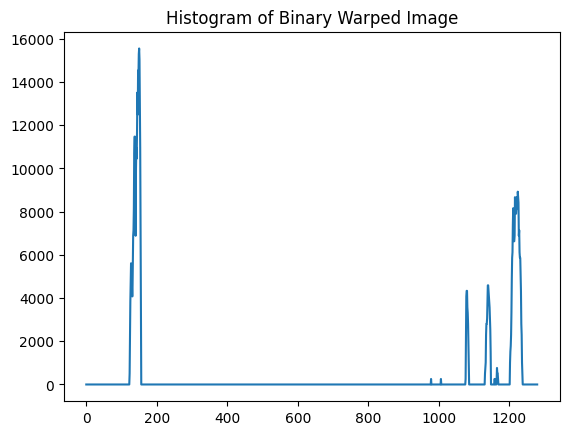

In [5]:
# Step 1: Calculate histogram
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:], axis=0)

plt.plot(histogram)
plt.title('Histogram of Binary Warped Image')
plt.show()

midpoint = int(histogram.shape[0] / 2)
left_base = np.argmax(histogram[:midpoint])
right_base = np.argmax(histogram[midpoint:]) + midpoint

In [6]:
# Step 2: Set up sliding windows
nwindows = 9
window_height = int(binary_warped.shape[0] / nwindows)
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

left_current = left_base
right_current = right_base
left_lane_inds = []
right_lane_inds = []

msk = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

In [7]:
# Step 3: Sliding windows loop
for window in range(nwindows):
    win_y_low = binary_warped.shape[0] - (window + 1) * window_height
    win_y_high = binary_warped.shape[0] - window * window_height
    win_xleft_low = left_current - margin
    win_xleft_high = left_current + margin
    win_xright_low = right_current - margin
    win_xright_high = right_current + margin

    cv2.rectangle(msk, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
    cv2.rectangle(msk, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    if len(good_left_inds) > minpix:
        left_current = int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        right_current = int(np.mean(nonzerox[good_right_inds]))
    cv2.rectangle(msk, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
    cv2.rectangle(msk, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

In [8]:
# Step 4: Concatenate arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

In [9]:
# Step 5: Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

In [10]:
# Step 6: Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [11]:
# Step 7: Visualization
msk[lefty, leftx] = [0, 0, 255]
msk[righty, rightx] = [0, 0, 255]

In [12]:
print("Left fit coefficients:", left_fit)
print("Right fit coefficients:", right_fit)
print("Left lane line y-coordinates:", lefty)
print("Left lane line x-coordinates:", leftx)
print("Right lane line y-coordinates:", righty)
print("Right lane line x-coordinates:", rightx)

Left fit coefficients: [-2.65347237e-05 -4.15068255e-02  1.70362193e+02]
Right fit coefficients: [7.54928320e-05 1.87673088e-01 1.05850669e+03]
Left lane line y-coordinates: [642 642 643 ...  77  77  78]
Left lane line x-coordinates: [130 131 129 ... 169 170 170]
Right lane line y-coordinates: [640 640 640 ...   1   1   1]
Right lane line x-coordinates: [1202 1203 1204 ... 1064 1065 1066]


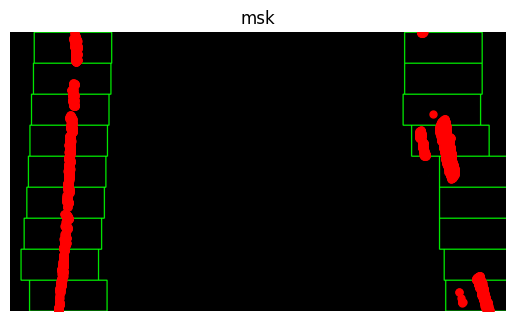

In [13]:
plt.imshow(msk, cmap='gray')
plt.plot(leftx, lefty, 'o', color='red', markersize=5)
plt.plot(rightx, righty, 'o', color='red', markersize=5)
plt.title('msk')
plt.axis('off')
plt.show()